# Machine Learning approach to analyze 3-Year prognostication for patients with brain arteriovenous malformation (bAVM) after stereotactic radiosurgery (SRS): a study for a small and heterogeneous group in Peru.

> [Dataset]
---

## Util functions:

In [ ]:
!pip install dython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.6.2-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (9.4 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3


In [ ]:
!pip uninstall --yes matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.6.2
Uninstalling matplotlib-3.6.2:
  Successfully uninstalled matplotlib-3.6.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp38-cp38-manylinux1_x86_64.whl (13.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dython 0.7.2 requires matplotlib>=3.4.3, but you have matplotlib 3.1.3 which is incompatible.


In [ ]:
# Libs
from google.colab import drive
from pathlib import Path

import pandas as pd
import numpy as np

import joblib
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from dython.nominal import associations

import scipy.stats as stats

In [ ]:
# Functions
def printBalance(data, field_grouping):
    print("\nQuantity for elements by Class :")
    target_count = data[field_grouping].value_counts()
    target_count.plot(kind='bar', title='Count (' + field_grouping + ')'); 
    print('Total  :', data.shape[0])

def chiSquareTest(data, var, the_class):
    # **Chi-Square test:** 
    # In addition to visualizing the data, it is good practice to always perform an appropriate statistical test, even if there is no noticeable bias in the visual inspection.
    sns.countplot(x=the_class, hue=var, data=data, palette=['#EF7CE2', '#0F65DE'])
    plt.show()
    # Create the contingency table
    contingency_table = pd.crosstab(data[var], data[the_class])
    print(contingency_table)

    # Perform the homogeneity test
    chi2, p, _, _ = stats.chi2_contingency(contingency_table, correction=False)
    print("var: "  + var)
    print('Chi-square test: chi2 stats = %.3f p-value = %.3f' % (chi2, p))

def shapiroTest(data, var, the_class):
    # **Shapiro test:** 
    # Let's check for any imbalance with respect to **age**. 
    # The null-hypothesis of this test is that the population is normally distributed.
    # *(e.g., for an alpha level of .05, a data set with a p value of less than .05 rejects the null hypothesis that the data are from a normally distributed population)*
    var_0 = data[data[the_class] == 0][var]
    var_1 = data[data[the_class] == 1][var]

    # Plot normal curve
    sns.kdeplot(var_0,
                color='#881393',
                label='Var class 0',
                shade=True)
    sns.kdeplot(var_1,
                color='#0F65DE',
                label='Var class 1',
                shade=True)
    plt.legend()
    plt.show()

    # Shapiro test for normality
    _, p_var_0_normality = stats.shapiro(var_0)
    _, p_var_1_normality = stats.shapiro(var_1)

    print('Class 0: Normality test: p-value = %.3f' % p_var_0_normality)
    print('Class 1: Normality test: p-value = %.3f' % p_var_1_normality)

    # Descriptives
    print('\n'+var)
    print('Class 0: Mean(SD) = %.2f(%.2f)' % (var_0.mean(), var_0.std()))
    print('Class 1: Mean(SD) = %.2f(%.2f)' % (var_1.mean(), var_1.std()))  

def studentTest(data, var, the_class):
    var_0 = data[data[the_class] == 0][var]
    var_1 = data[data[the_class] == 1][var]
    t_stats, p_var = stats.ttest_ind(var_0, var_1)
    print(var)
    print("Student's t-test: t stats = %.3f, p-value = %.3f" % (t_stats, p_var))

## Setup Environment

In [ ]:
# sklearn
import sklearn
print('Scikit-learn version: ',sklearn.__version__)

# Python
import platform
print('Python version: ', platform.python_version())

Scikit-learn version:  1.0.2
Python version:  3.8.16


In [ ]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
%%bash 
MYPROJECT="/content/drive/MyDrive/UNI/DSc/Publications/Mirko/Paper_Propuesta/Propuesta01/Modeling"
ls -l "$MYPROJECT"
echo "$MYPROJECT" > config.txt

total 878
-rw------- 1 root root  14593 Dec 13 00:08 bAVM-Dataset Pre-Processing
-rw------- 1 root root 856024 Dec 12 22:59 bAVM-Modeling (Decision Trees DT)
drwx------ 2 root root   4096 Nov 30 15:23 bkp
drwx------ 2 root root   4096 Nov  2 22:23 dataset
drwx------ 2 root root   4096 Nov  3 00:41 model
drwx------ 2 root root   4096 Dec 13 00:07 output
-rw------- 1 root root   6919 Dec 12 22:57 Util.ipynb
drwx------ 2 root root   4096 Nov  3 00:41 utils


### General definitions:

In [ ]:
# Target
CLASS = 'curation'

# Project & working folders
project_folder = open('config.txt').readline().rstrip('\n')
dataset_folder = "/".join([project_folder,"dataset"])
output_folder = "/".join([project_folder,"output"])

## **Part I - Data Pre-Processing**
---

### Loading Dataset:

In [ ]:
# Importing dataset
dataset_name_csv = 'dataset-bAVM-msalas.v1.2.csv'
dataset_full = pd.read_csv("/".join([dataset_folder, dataset_name_csv]))

In [ ]:
dataset_full.head(5)

id  gender  age  residence  ocupation  education_level  health_insurance  \
0   1       1   11          1          6                2                 3   
1   2       0    8          1          6                2                 3   
2   3       0   32          1          3                3                 5   
3   4       0   52          2          3                3                 1   
4   5       1   38          1          1                4                 1   

   haemorrhage  haemorrhage_type  headache  ...  venous_stenosis  volumen_avm  \
0            1                 1         1  ...                0         2.00   
1            1                 3         1  ...                0         2.00   
2            1                 1         1  ...                0         4.00   
3            1                 4         1  ...                1         5.00   
4            0                 4         1  ...                0         1.96   

   num_radiosurgeries  mri_examination  ct_examination  das_examination  \
0                   1                1               1                1   
1                   1                1               1                1   
2                   1                1               1                1   
3                   1                1               1                1   
4                   1                1               0                1   

   num_isocenters  radiation_dosis  isodosis  curation  
0               1             18.0        80         1  
1               1             18.0        80         1  
2               1             18.0        80         1  
3               2             12.5        50         1  
4               1             18.0        80         1  

[5 rows x 46 columns]

In [ ]:
dataset_full.describe()

id      gender         age   residence   ocupation  \
count  202.000000  202.000000  202.000000  202.000000  202.000000   
mean   101.500000    0.529703   27.628713    1.202970    4.153465   
std     58.456537    0.500357   14.901526    0.427175    2.228538   
min      1.000000    0.000000    4.000000    1.000000    1.000000   
25%     51.250000    0.000000   17.000000    1.000000    2.000000   
50%    101.500000    1.000000   25.000000    1.000000    4.000000   
75%    151.750000    1.000000   36.000000    1.000000    6.000000   
max    202.000000    1.000000   68.000000    3.000000    8.000000   

       education_level  health_insurance  haemorrhage  haemorrhage_type  \
count       202.000000        202.000000   202.000000        202.000000   
mean          3.069307          3.089109     0.767327          2.376238   
std           0.736503          1.075267     0.423585          1.351995   
min           1.000000          1.000000     0.000000          1.000000   
25%           3.000000          3.000000     1.000000          1.000000   
50%           3.000000          3.000000     1.000000          2.000000   
75%           4.000000          4.000000     1.000000          4.000000   
max           4.000000          5.000000     1.000000          4.000000   

         headache  ...  venous_stenosis  volumen_avm  num_radiosurgeries  \
count  202.000000  ...       202.000000   202.000000          202.000000   
mean     0.881188  ...         0.257426     6.297094            1.356436   
std      0.324371  ...         0.438302     8.326947            1.555502   
min      0.000000  ...         0.000000     0.062500            1.000000   
25%      1.000000  ...         0.000000     1.680000            1.000000   
50%      1.000000  ...         0.000000     4.000000            1.000000   
75%      1.000000  ...         1.000000     7.810000            1.000000   
max      1.000000  ...         1.000000    75.000000           10.000000   

       mri_examination  ct_examination  das_examination  num_isocenters  \
count       202.000000      202.000000       202.000000      202.000000   
mean          0.975248        0.648515         0.945545        1.351485   
std           0.155756        0.478620         0.227478        0.555589   
min           0.000000        0.000000         0.000000        1.000000   
25%           1.000000        0.000000         1.000000        1.000000   
50%           1.000000        1.000000         1.000000        1.000000   
75%           1.000000        1.000000         1.000000        2.000000   
max           1.000000        1.000000         1.000000        4.000000   

       radiation_dosis    isodosis    curation  
count       202.000000  202.000000  202.000000  
mean         17.854505   69.306931    0.826733  
std           4.440948   14.369497    0.379419  
min          10.000000   50.000000    0.000000  
25%          16.000000   50.000000    1.000000  
50%          17.000000   80.000000    1.000000  
75%          18.000000   80.000000    1.000000  
max          40.000000   90.000000    1.000000  

[8 rows x 46 columns]

In [ ]:
# Columns
dataset_full.columns.tolist()

['id',
 'gender',
 'age',
 'residence',
 'ocupation',
 'education_level',
 'health_insurance',
 'haemorrhage',
 'haemorrhage_type',
 'headache',
 'seizures',
 'encephalomalacia',
 'other_diseases',
 'deficit',
 'karnofsky_scale',
 'glasgow_coma_scale',
 'spetzler_martin_scale',
 'buffalo_scale',
 'virginia_scale',
 'prev_cran_surgery',
 'embolization',
 'embolization_agent',
 'prev_surgery_or_embolization',
 'localization_avm',
 'venous_aneurysm',
 'arterial_aneurysm',
 'dolichoectasia ',
 'num_afferent_vessels',
 'depth_avm',
 'diameter_avm',
 'side_avm',
 'expansion_shape_avm',
 'type_venous_drainage',
 'eloquence',
 'type_circulation_drainage',
 'blood_flow_velocity',
 'venous_stenosis',
 'volumen_avm',
 'num_radiosurgeries',
 'mri_examination',
 'ct_examination',
 'das_examination',
 'num_isocenters',
 'radiation_dosis',
 'isodosis',
 'curation']

### Missing data verification:

In [ ]:
null_lin_bool = dataset_full.isnull().any(axis=1)
null_cols = dataset_full.columns[dataset_full.isnull().any(axis=0)]

n_null = dataset_full.isnull().sum().sum()
print('Number of missing data = %d' % n_null)
subj_null = dataset_full[null_lin_bool].index
print('IDs: %s' % (', ').join(subj_null.tolist()))

Number of missing data = 0
IDs: 


In [ ]:
dataset_full = dataset_full.dropna()
print('Number of participants = %d' % dataset_full.shape[0])

Number of participants = 202


### Feature selection (removing features):

In [ ]:
# Expert judgment
COL_REMOVE=["id","mri_examination","ct_examination","das_examination","residence","education_level","health_insurance"]
dataset_full.drop(COL_REMOVE, axis=1, errors='ignore', inplace=True)

print('Number of features = %d' % dataset_full.shape[1])
print('Number of participants = %d' % dataset_full.shape[0])

Number of features = 39
Number of participants = 202


### Correlation analysis:

In [ ]:
numerical_columns = ['diameter_avm', 'volumen_avm', 'radiation_dosis']
categorical_columns = list(set(dataset_full.columns.tolist()) - set(numerical_columns) - set([CLASS]))

print('\nnumerical_columns: %d %s' % (len(numerical_columns), numerical_columns))
print('\ncategorical_columns: %d %s' % (len(categorical_columns), categorical_columns))


numerical_columns: 3 ['diameter_avm', 'volumen_avm', 'radiation_dosis']

categorical_columns: 35 ['prev_cran_surgery', 'num_isocenters', 'age', 'seizures', 'glasgow_coma_scale', 'venous_aneurysm', 'eloquence', 'localization_avm', 'num_afferent_vessels', 'num_radiosurgeries', 'headache', 'type_venous_drainage', 'karnofsky_scale', 'deficit', 'haemorrhage', 'isodosis', 'embolization', 'gender', 'expansion_shape_avm', 'type_circulation_drainage', 'blood_flow_velocity', 'side_avm', 'ocupation', 'arterial_aneurysm', 'spetzler_martin_scale', 'virginia_scale', 'other_diseases', 'buffalo_scale', 'prev_surgery_or_embolization', 'embolization_agent', 'haemorrhage_type', 'encephalomalacia', 'depth_avm', 'dolichoectasia ', 'venous_stenosis']


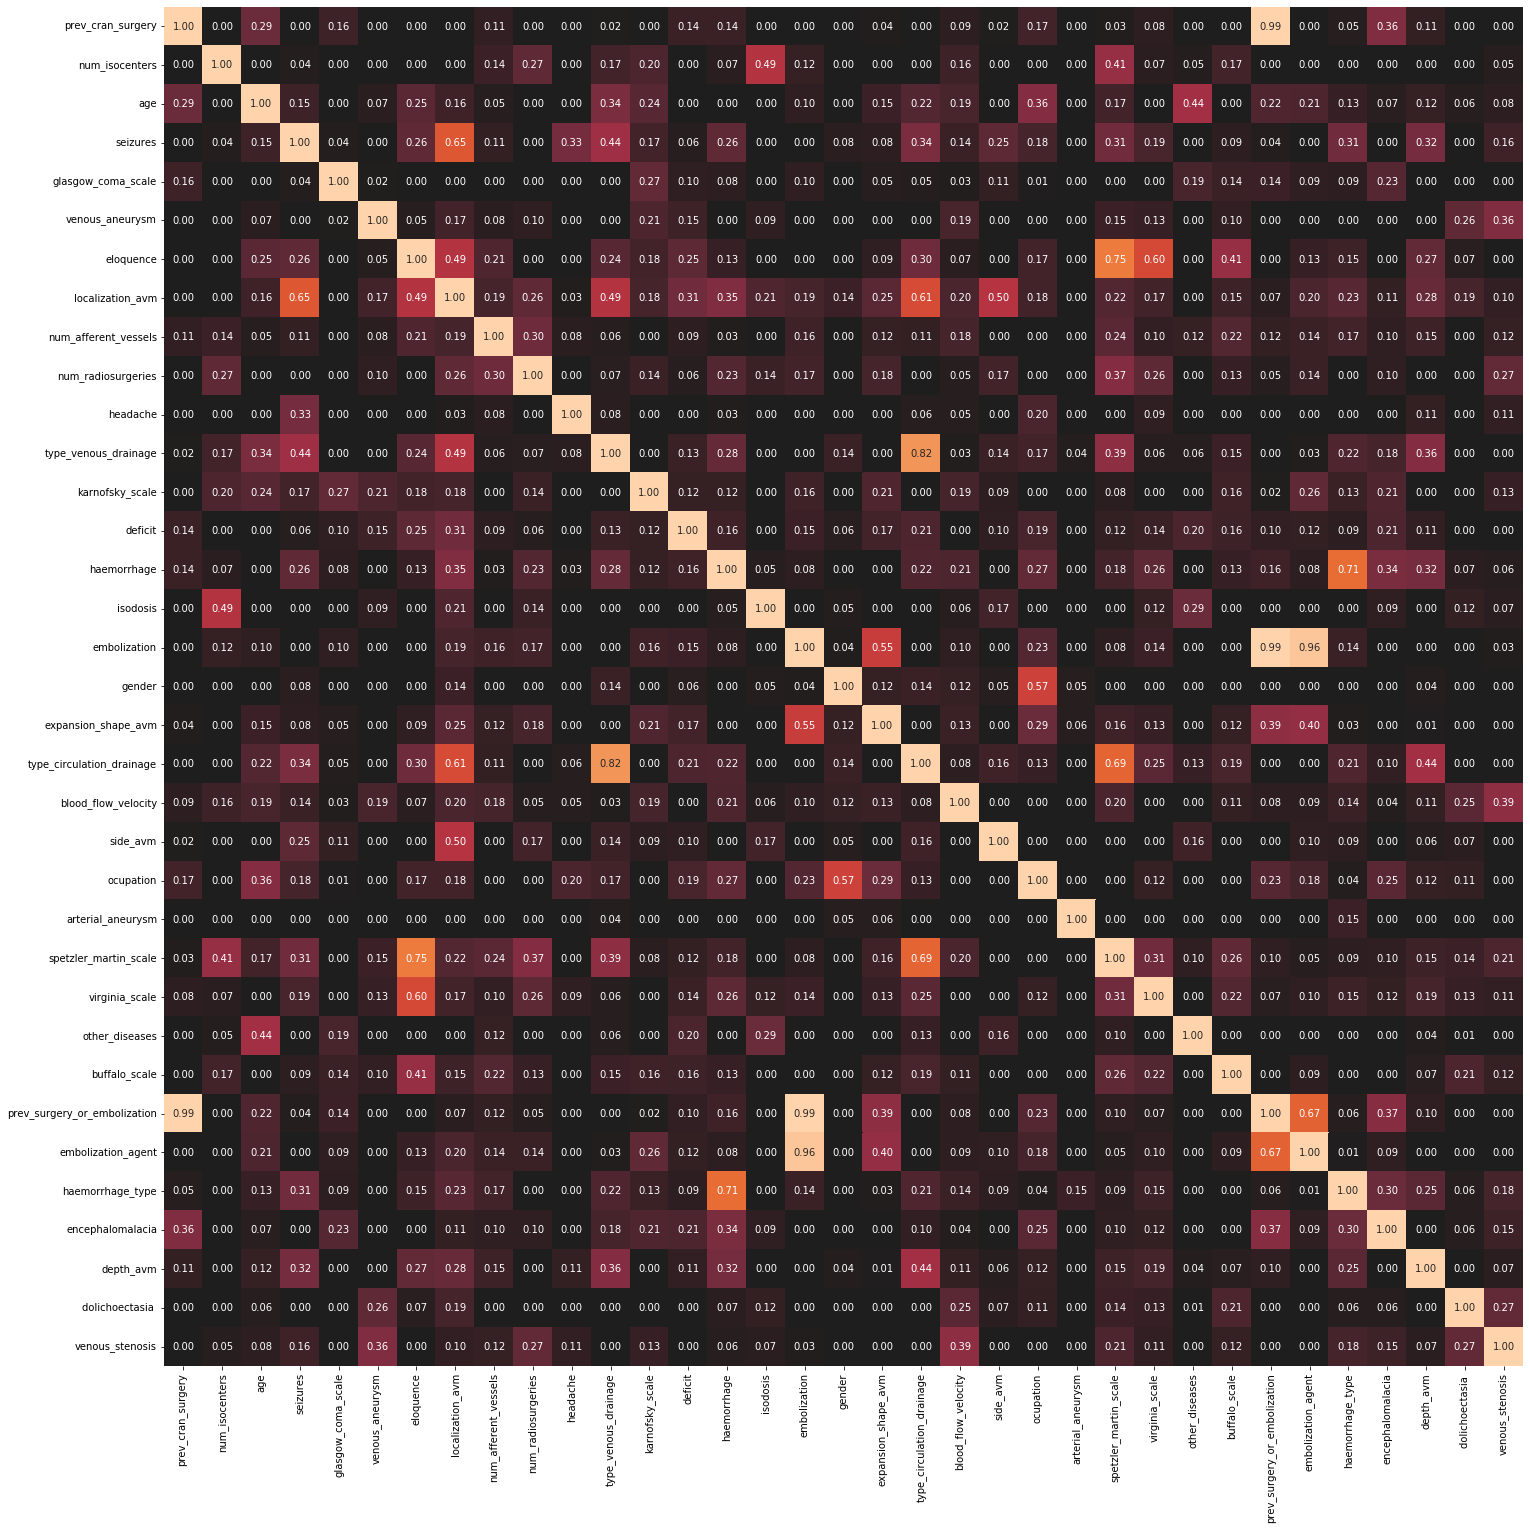

In [ ]:
selected_column= dataset_full[categorical_columns]
categorical_df = selected_column.copy()
categorical_correlation= associations(categorical_df, nominal_columns=categorical_columns, numerical_columns=None, nom_nom_assoc='cramer',figsize=(25,25), cbar=False)


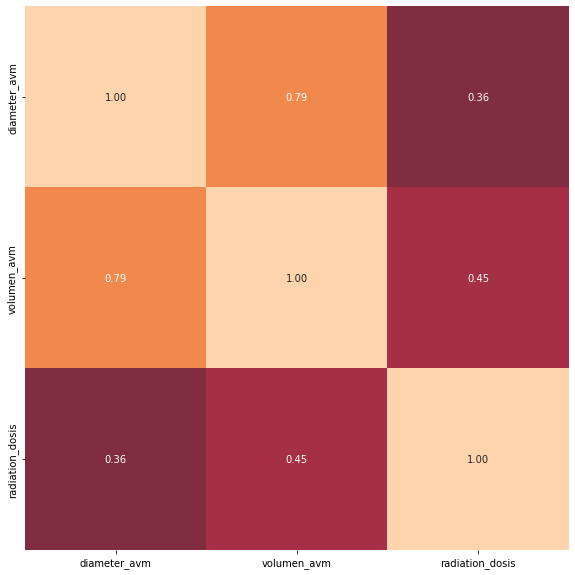

In [ ]:
selected_column= dataset_full[numerical_columns]
numerical_df = selected_column.copy()
categorical_correlation= associations(numerical_df, nominal_columns=None, numerical_columns=numerical_columns, num_num_assoc='pearson',figsize=(10,10), cbar=False)

#### Remove correlated variables

In [ ]:
# Corr > 0.7
COL_REMOVE_CORR=["haemorrhage_type","embolization_agent","prev_surgery_or_embolization","spetzler_martin_scale","type_circulation_drainage","diameter_avm"]
dataset_full.drop(COL_REMOVE_CORR, axis=1, errors='ignore', inplace=True)

print('Number of features = %d' % dataset_full.shape[1])
print('Number of participants = %d' % dataset_full.shape[0])

Number of features = 33
Number of participants = 202


### Verify data distributions:

#### Confounding variables:

There are many potential confounding variables one might want to inspect. Here, we will investigate two obvious ones: **gender** and **age**. 

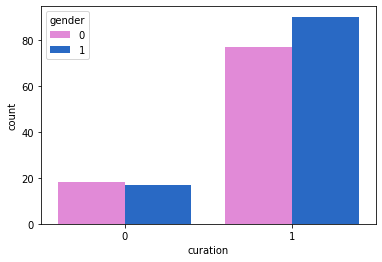

curation   0   1
gender          
0         18  77
1         17  90
var: gender
Chi-square test: chi2 stats = 0.329 p-value = 0.566


In [ ]:
chiSquareTest(dataset_full, 'gender', CLASS)

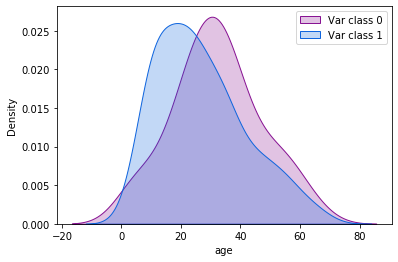

Class 0: Normality test: p-value = 0.674
Class 1: Normality test: p-value = 0.000

age
Class 0: Mean(SD) = 31.97(14.68)
Class 1: Mean(SD) = 26.72(14.83)


In [ ]:
shapiroTest(dataset_full, 'age', CLASS)

In [ ]:
studentTest(dataset_full, 'age', CLASS)

age
Student's t-test: t stats = 1.909, p-value = 0.058


### Split original data in Training and Test:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [ ]:
# Default parameters
TEST_SIZE = 0.25

# Guarantee the same result
RANDOM_SEED = 5

In [ ]:
# Training y Test (Training Set aka working Set)
training_set, test_set = train_test_split(dataset_full, test_size = TEST_SIZE, random_state = RANDOM_SEED)

In [ ]:
# Saving files
training_set.to_csv("/".join([output_folder,'training_set.csv']), index=False) 
test_set.to_csv("/".join([output_folder,'test_set.csv']), index=False) 

### Imbalance data:

#### Training set:


Quantity for elements by Class :
Total  : 151


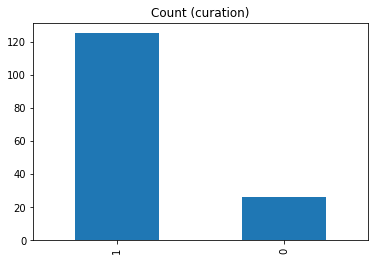

In [ ]:
printBalance(training_set, CLASS)

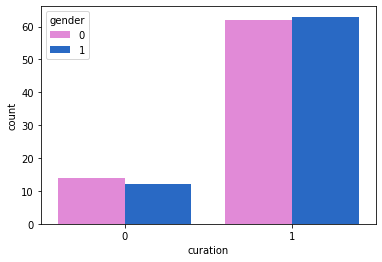

curation   0   1
gender          
0         14  62
1         12  63
var: gender
Chi-square test: chi2 stats = 0.155 p-value = 0.694


In [ ]:
chiSquareTest(training_set, 'gender', CLASS)

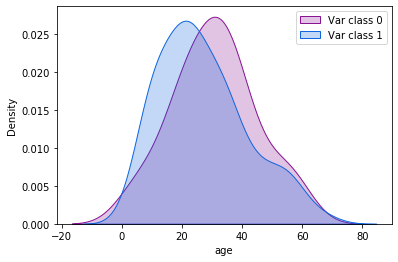

Class 0: Normality test: p-value = 0.766
Class 1: Normality test: p-value = 0.000

age
Class 0: Mean(SD) = 30.73(13.79)
Class 1: Mean(SD) = 27.04(14.60)


In [ ]:
shapiroTest(training_set, 'age', CLASS)

In [ ]:
studentTest(training_set, 'age', CLASS)

age
Student's t-test: t stats = 1.183, p-value = 0.239


#### Testing set:


Quantity for elements by Class :
Total  : 51


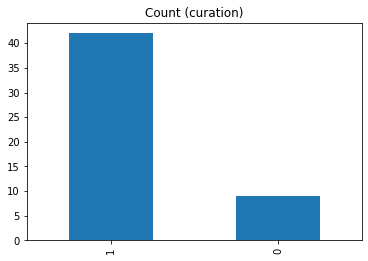

In [ ]:
printBalance(test_set, CLASS)

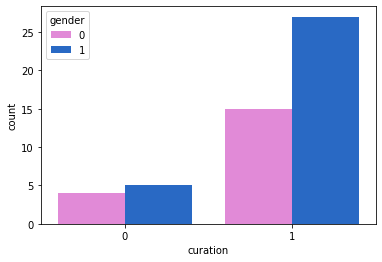

curation  0   1
gender         
0         4  15
1         5  27
var: gender
Chi-square test: chi2 stats = 0.242 p-value = 0.623


In [ ]:
chiSquareTest(test_set, 'gender', CLASS)

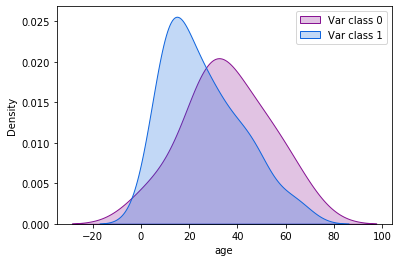

Class 0: Normality test: p-value = 0.902
Class 1: Normality test: p-value = 0.005

age
Class 0: Mean(SD) = 35.56(17.39)
Class 1: Mean(SD) = 25.76(15.62)


In [ ]:
shapiroTest(test_set, 'age', CLASS)

In [ ]:
studentTest(test_set, 'age', CLASS)

age
Student's t-test: t stats = 1.674, p-value = 0.100


### Balance the data:
https://imbalanced-learn.org/dev/over_sampling.html#smote-variants

In [ ]:
from imblearn.over_sampling import SMOTENC
working_set = training_set.copy()
num_columns = working_set.shape[1]
dataset_columns = working_set.columns

# Values to be processed
X = working_set.iloc[:, 0:num_columns - 1].values
y = working_set.iloc[:, num_columns - 1].values

cat_features_name = list(dataset_columns)
# print(cat_features_name)

st = set(categorical_columns)
cat_features = [i for i, e in enumerate(cat_features_name) if e in st] #Indices
# print(cat_features) 

# SMOTE
smote_nc = SMOTENC(categorical_features=cat_features, random_state=0)
X_resampled, y_resampled = smote_nc.fit_resample(X, y)

balanced_dataset = np.column_stack((X_resampled, y_resampled))

# balanced dataset
bal_working_set = pd.DataFrame(balanced_dataset,columns=dataset_columns, dtype=np.float64)

bal_working_set.to_csv("/".join([output_folder,'training_set_bal.csv']), index=False) 
print ("\nFinal balanced dataset: ", bal_working_set.shape)
bal_working_set.tail(5)


Final balanced dataset:  (250, 33)


gender   age  ocupation  haemorrhage  headache  seizures  \
245     1.0  32.0        2.0          0.0       1.0       1.0   
246     0.0  27.0        2.0          1.0       1.0       1.0   
247     1.0  54.0        1.0          0.0       1.0       1.0   
248     1.0  36.0        1.0          1.0       1.0       1.0   
249     1.0  29.0        2.0          0.0       1.0       1.0   

     encephalomalacia  other_diseases  deficit  karnofsky_scale  ...  \
245               0.0             0.0      1.0             80.0  ...   
246               0.0             0.0      1.0             80.0  ...   
247               0.0             0.0      4.0             80.0  ...   
248               0.0             0.0      4.0             80.0  ...   
249               0.0             0.0      1.0             80.0  ...   

     type_venous_drainage  eloquence  blood_flow_velocity  venous_stenosis  \
245                   1.0        1.0                  3.0              1.0   
246                   2.0        1.0                  1.0              0.0   
247                   2.0        1.0                  3.0              1.0   
248                   1.0        1.0                  3.0              1.0   
249                   1.0        1.0                  3.0              1.0   

     volumen_avm  num_radiosurgeries  num_isocenters  radiation_dosis  \
245     9.765792                 1.0             1.0        16.000000   
246    14.097162                 1.0             1.0        17.592844   
247     9.529722                 1.0             1.0        15.750844   
248    16.881169                 1.0             2.0        16.568164   
249     6.457576                 1.0             1.0        17.662727   

     isodosis  curation  
245      80.0       0.0  
246      80.0       0.0  
247      80.0       0.0  
248      50.0       0.0  
249      80.0       0.0  

[5 rows x 33 columns]


Quantity for elements by Class :
Total  : 250


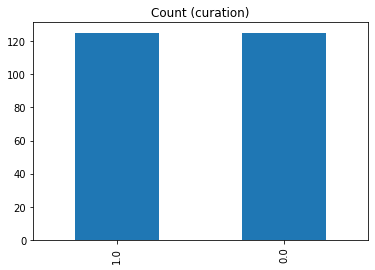

In [ ]:
printBalance(bal_working_set, CLASS)

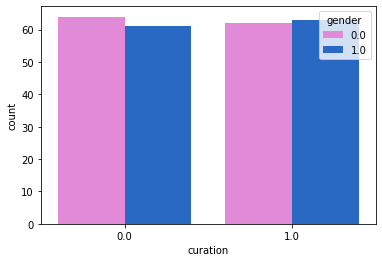

curation  0.0  1.0
gender            
0.0        64   62
1.0        61   63
var: gender
Chi-square test: chi2 stats = 0.064 p-value = 0.800


In [ ]:
chiSquareTest(bal_working_set, 'gender', CLASS)

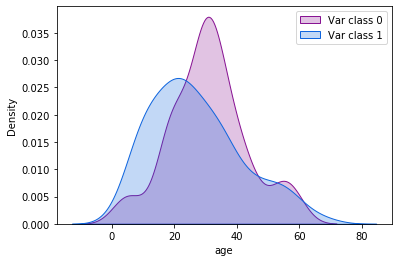

Class 0: Normality test: p-value = 0.000
Class 1: Normality test: p-value = 0.000

age
Class 0: Mean(SD) = 30.96(12.22)
Class 1: Mean(SD) = 27.04(14.60)


In [ ]:
shapiroTest(bal_working_set, 'age', CLASS)

In [ ]:
studentTest(bal_working_set, 'age', CLASS)

age
Student's t-test: t stats = 2.302, p-value = 0.022
